# Method 1: Watershed 

In [41]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt


In [244]:
img = cv.imread('./sample_images/image3.png',)
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

In [245]:
# option1
#retval, threshold = cv.threshold(gray, 150, 255, cv.THRESH_BINARY)

# option2
ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV + cv.THRESH_OTSU) #+cv.THRESH_OTSU


### Plotting the original image and first segmentation 

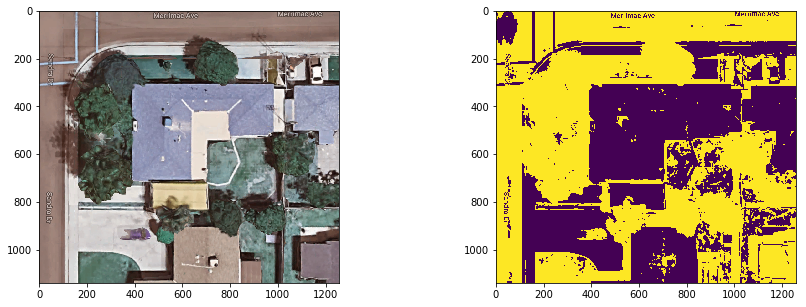

In [246]:
fig,ax = plt.subplots(ncols=2,nrows=1, figsize=(15,5))
ax[0].imshow(img)
ax[1].imshow(thresh)

fig.show()

### Testing to blur the images (not using this yet)

In [247]:
#blur = cv.blur(img,(20,20))
#plt.imshow(blur)

## Using another version of the filters above (this time with better results)

In [248]:
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

# option1
retval, threshold = cv.threshold(gray, 150, 255, cv.THRESH_BINARY)
# option2
ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV + cv.THRESH_OTSU) #+cv.THRESH_OTSU


In [249]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 1)

# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=7)

# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.05*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)


### We are looking for an image like the one on the very right, with the house 

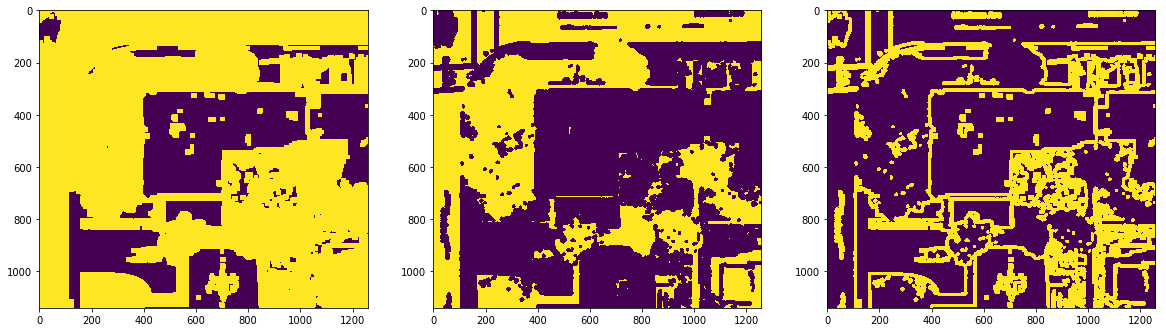

In [250]:
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(20,10))
#plt.figure()

ax[0].imshow(sure_bg)
ax[1].imshow(sure_fg)
ax[2].imshow(unknown)

fig.show()

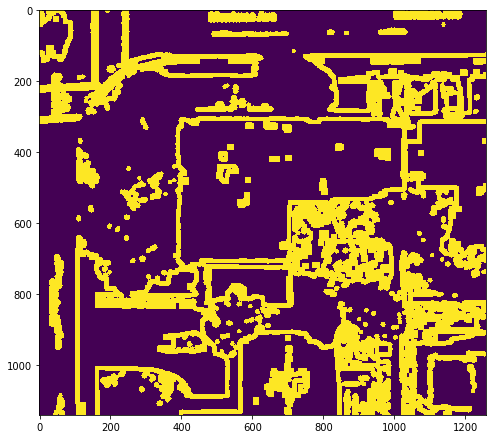

In [251]:
plt.imshow(unknown)

In [252]:
unknown2 = unknown.copy()
unknown2[unknown2 == 255] = 0
unknown2[unknown2 == 0] = 255

In [253]:
unknown2 = 255 - unknown

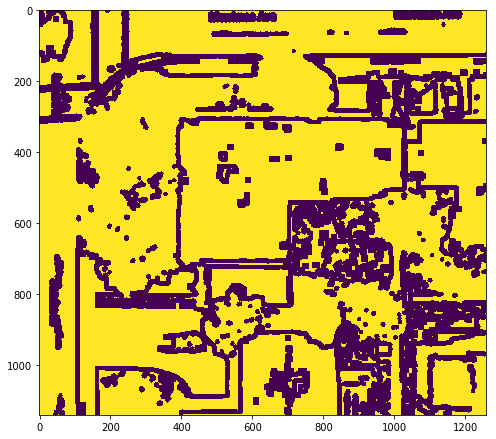

In [254]:
plt.imshow(unknown2)

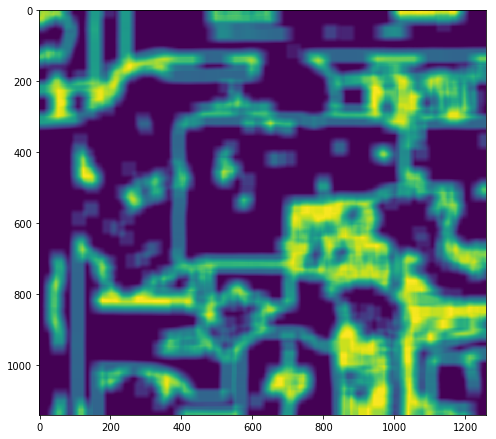

In [255]:
blur2 = cv.blur(unknown,(40,40))
plt.imshow(blur2)

# run k-nearest on segmented image

In [256]:
Z = img.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

In [257]:
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
ret,label,center=cv.kmeans(Z,K,None,criteria,100,cv.KMEANS_RANDOM_CENTERS)

center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

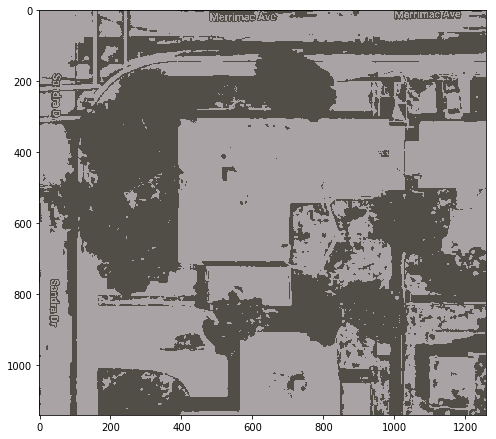

In [258]:
plt.imshow(res2)

# Contours

unknown2 = unknown2.astype("int8")

In [259]:
img2 = img.copy()

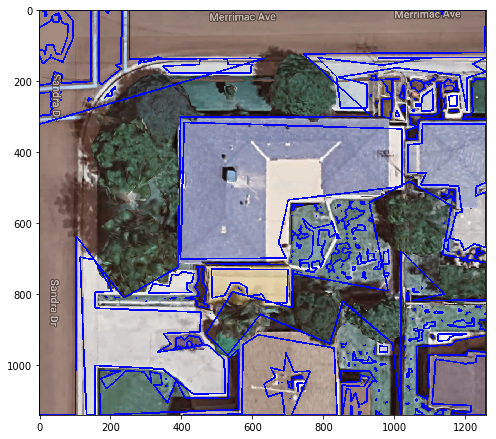

In [260]:
plt.rcParams["figure.figsize"] = (8,8)

_, contours, _ = cv.findContours(unknown2, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

for cont in contours:
    
    # epsilon is the maximum distance between the contour and the approximated contour
    # epsilon = error_rate * actual_arc_length
    
    epsilon = 0.01 * cv.arcLength(cont, True)
    
    # use approxPolyDP to approximate the polygon
    approx = cv.approxPolyDP(cont, epsilon, True)
    
    img2 = cv.drawContours(img2, [approx], 0, (0,0,255), 3)
   

plt.figure("Drawing contours")
plt.imshow(img2)
plt.show()

In [261]:
centre

(150.0, 150.0)

In [262]:
centre = (img.shape[0]/2, img.shape[1]/2)

valid_contours = []

for cont in contours:

    dist = cv.pointPolygonTest(cont,centre,False)
    if  dist != -1:
        valid_contours += [cont]

print("{} contour(s) found".format(len(valid_contours)))
    

1 contour(s) found


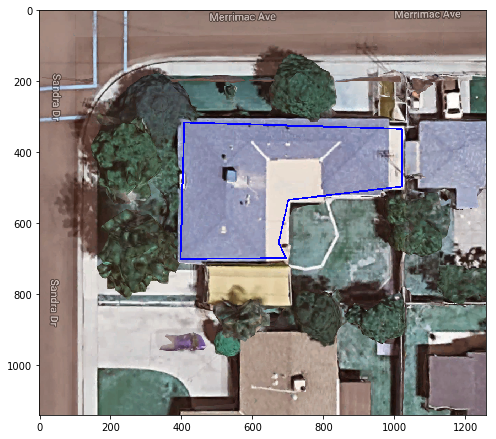

In [263]:
plt.rcParams["figure.figsize"] = (8,8)

img2 = img.copy()

_, contours, _ = cv.findContours(unknown2, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

for cont in valid_contours:
    
    # epsilon is the maximum distance between the contour and the approximated contour
    # epsilon = error_rate * actual_arc_length
    
    epsilon = 0.01 * cv.arcLength(cont, True)
    
    # use approxPolyDP to approximate the polygon
    approx = cv.approxPolyDP(cont, epsilon, True)
    
    img2 = cv.drawContours(img2, [approx], 0, (0,0,255), 3)
   

plt.figure("Drawing contours")
plt.imshow(img2)
plt.show()

In [264]:
surface = cv.contourArea(valid_contours[0])
surface / (img.shape[0] * img.shape[1])

0.12439091568348534

### Applying further filters

In [22]:
### # Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

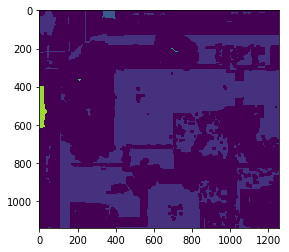

In [23]:
plt.imshow(markers)

In [11]:
markers = cv.watershed(img,markers)
img[markers == -1] = [255,0,0]

# Method 2: K-Means

In [116]:
import numpy as np
import cv2

img = cv2.imread('./sample_images/image3.png')
#img = cv2.cvtColor(img,cv.COLOR_BGR2GRAY)
Z = img.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

In [117]:
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)


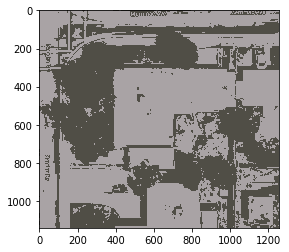

In [118]:

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

plt.imshow(res2)